In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os 
import numpy as np
from tensorflow import keras
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from methods_audio import data_handling
from methods_audio import data_augmentation
from methods_audio import denoising 
from methods_audio import model_performance_training

/Users/rosameliacarioni/miniconda3/envs/bach_thesis_4/lib/python3.9/site-packages/tensorflow_io-0.32.0-py3.9-macosx-11.0-arm64.egg/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/Users/rosameliacarioni/miniconda3/envs/bach_thesis_4/lib/python3.9/site-packages/tensorflow_io-0.32.0-py3.9-macosx-11.0-arm64.egg/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ["[Errno 2] The file to load file system plugin from does not exist.: '/Users/rosameliacarioni/miniconda3/envs/bach_thesis_4/lib/python3.9/site-packages/tensorflow_io-0.32.0-py3.9-macosx-11.0-arm64.egg/tensorflow_io/python/ops/libtensorflow_io_plugins.so'"]
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/Users/rosameliacarioni/miniconda3/envs/bach_thesis_4/lib/python3.9/site-packages/tensorflow_io-0.32.0-py3.9-macosx-11.0-arm64.egg/tensorflow_io/python/ops/__init__.py:104: UserWarning

# 1. Get data (file names)

In [8]:
data = data_handling.get_data2()

# 2. Read data (transforming file names into waves) <br>
Additionally, the mean is removed and the data is normalized. 

In [9]:
data = data.map(data_handling.read_in_data) 

# 3. Get input for model training 

In [10]:
samples, labels = data_handling.extract_samples_labels(data)

# 4. Split data into train and validation sets

In [11]:
validation_set_size = 0.20
x_train, x_valid, y_train, y_valid = train_test_split(samples, labels, test_size= validation_set_size, random_state=123)

In [27]:
kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=123)
counter = 1
for train, test in kfold.split(samples, labels):
    if counter == 1: 
        x_train = np.array(samples)[train.astype(int)]
        y_train = np.array(labels)[train.astype(int)]
        x_valid = np.array(samples)[test.astype(int)]
        y_valid = np.array(labels)[test.astype(int)]


/var/folders/bz/rfsj8qqx5zsg0g1p0xdb1fkw0000gn/T/ipykernel_73433/2814398212.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.array(samples)[train.astype(int)]
/var/folders/bz/rfsj8qqx5zsg0g1p0xdb1fkw0000gn/T/ipykernel_73433/2814398212.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_valid = np.array(samples)[test.astype(int)]


# Testing stuff 

In [28]:

# 4. Transform numpy.ndarray into lists
x_train_list = x_train.tolist() 
y_train_list = y_train.tolist()
x_valid_list = x_valid.tolist()
# Augmentation 
#x_train_list, y_train_list = data_augmentation.time_augmentation(x_train_list, y_train_list)
# Denoising 
#x_train_list = denoising.apply_spectral(x_train_list)
#x_valid_list =denoising.apply_spectral(x_valid_list)
    


In [95]:
temp = tf.constant(x_train_list[0]) 
x_train_list[0]

array([-1.8622111e-01, -8.4498748e-02,  6.2050413e-02, ...,
       -7.9326428e-02, -1.7468377e-05,  6.2912464e-02], dtype=float32)

# My code

In [75]:

def convert_to_spectrogram(wave):
    # 1. Fast fourier transform 
    spectrogram = tf.signal.stft(wave, frame_length=256, frame_step=128)  # Paper: 'Automated detection of gunshots in tropical forests using CNN' 
    # frame_length =  window length in samples --- frame_step = number of samples to step
    # 'Time frequency compromise': if window size is small: you get good time resolution in exchange of poor frequency resolution 

    # 2. Obtain the magnitude of the STFT
    spectrogram = tf.abs(spectrogram)

    # 3. Tranform it into appropiate format for deep learning model by adding the channel dimension (in this case 1)
    #spectrogram = tf.expand_dims(spectrogram, axis=2)
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=8000, mels=number_mels_filterbanks, fmin=0, fmax=4000) 

    return mel_spectrogram

def transform_data (waves, type_transformation):
    transformed_signals = []

    if (type_transformation == 'spectrogram'):
        for wave in waves: 
            transformed_wave = convert_to_spectrogram(wave)
            transformed_signals.append(transformed_wave)

    return transformed_signals

In [76]:
# Transform data 
type_transformation = 'spectrogram'     
x_train_list_spect = transform_data(x_train_list, type_transformation)
x_valid_list_spect = transform_data(x_valid_list, type_transformation)

In [77]:
x_train_list_spect[0]

<tf.Tensor: shape=(63, 128), dtype=float32, numpy=
array([[ 0.        ,  0.34366196,  7.977546  , ...,  1.1113579 ,
         0.28673288,  0.48580346],
       [ 0.        ,  0.31705067,  7.3598084 , ...,  0.75905925,
         0.23374353,  0.24977933],
       [ 0.        ,  0.4627367 , 10.74167   , ...,  0.91965854,
         0.6500945 ,  0.34183088],
       ...,
       [ 0.        ,  0.0923989 ,  2.1448882 , ...,  1.2041254 ,
         2.0746644 ,  0.97043043],
       [ 0.        ,  0.3174775 ,  7.369717  , ...,  1.2924914 ,
         1.6624105 ,  0.5849212 ],
       [ 0.        ,  0.48789415, 11.325658  , ...,  1.2467413 ,
         1.4814098 ,  0.63983554]], dtype=float32)>

In [98]:
import librosa 
import librosa.display 
import matplotlib.pyplot as plt

file_path = 'data/train/ollie/ecoguns2.wav'
scale, sr = librosa.load(file_path)
scale

array([-0.01709157, -0.02160215, -0.02275129, ..., -0.00298083,
       -0.0013864 ,  0.        ], dtype=float32)

In [137]:
filter_banks = librosa.filters.mel(n_fft=256, sr = sr)

In [138]:
filter_banks.shape

(128, 129)

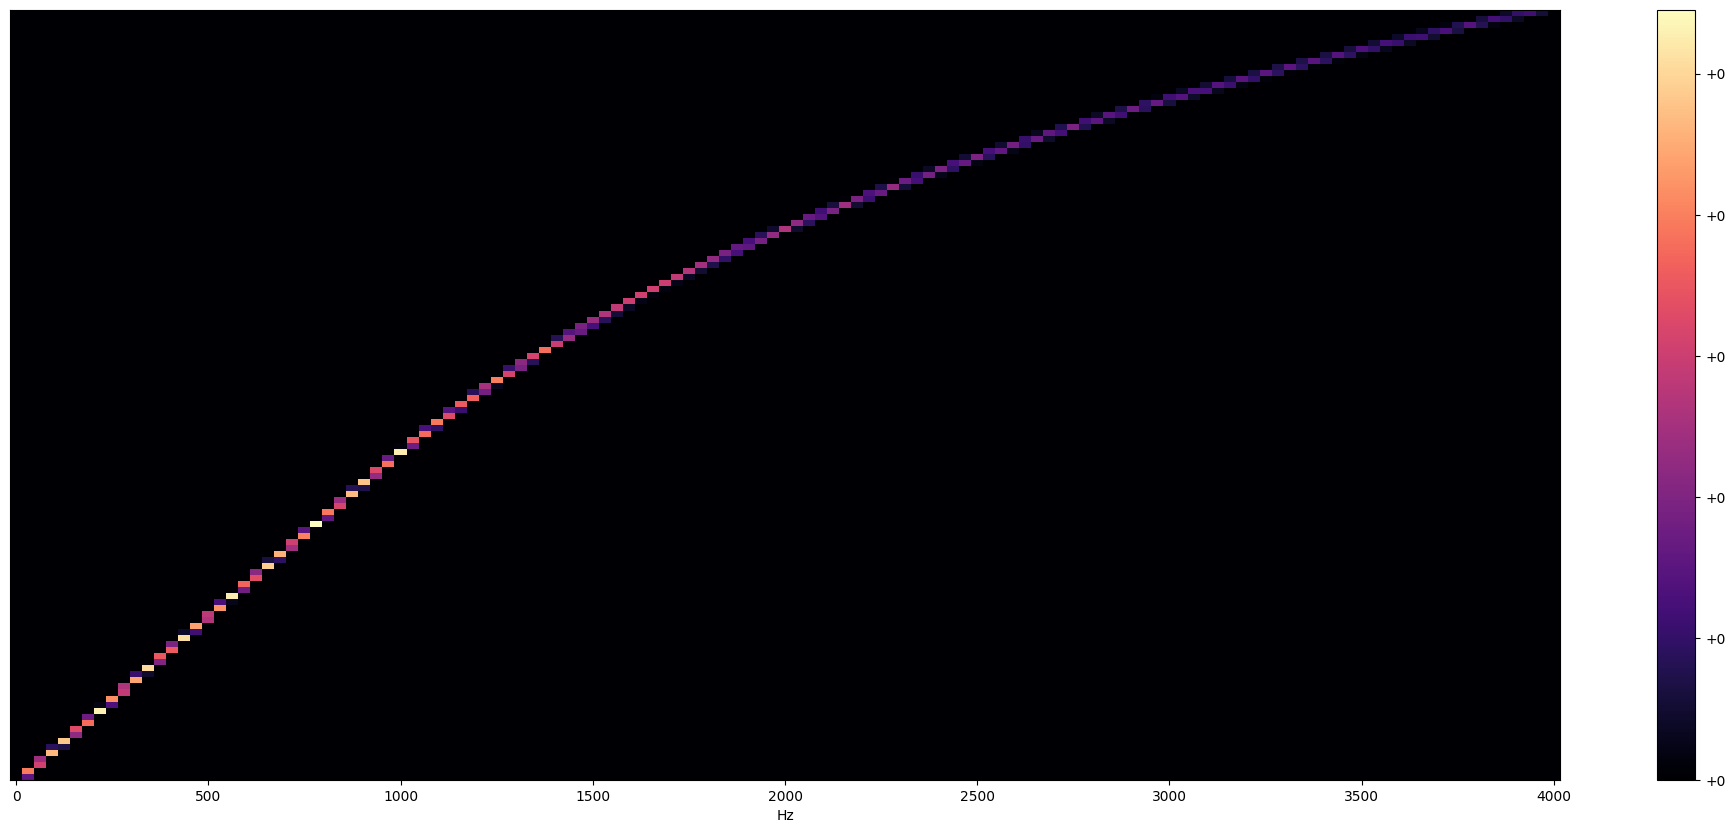

In [139]:
plt.figure(figsize=(25,10))
librosa.display.specshow(filter_banks, sr = sr, x_axis = "linear")
plt.colorbar(format = "%+2.f")
plt.show()

In [140]:
mel_spectrogram = librosa.feature.melspectrogram(scale, sr = sr, n_fft = 256, hop_length=128, n_mels = 128)
type(mel_spectrogram)

/var/folders/bz/rfsj8qqx5zsg0g1p0xdb1fkw0000gn/T/ipykernel_73433/4005028692.py:1: FutureWarning: Pass y=[-0.01709157 -0.02160215 -0.02275129 ... -0.00298083 -0.0013864
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_spectrogram = librosa.feature.melspectrogram(scale, sr = sr, n_fft = 256, hop_length=128, n_mels = 128)


numpy.ndarray

In [141]:
type(mel_spectrogram)
log_mel_spectogram = librosa.power_to_db(mel_spectrogram)
type(log_mel_spectogram)

numpy.ndarray

# My code

In [101]:
file_contents = tf.io.read_file(file_path) #retuns a string 
wave, _ = tf.audio.decode_wav(file_contents, desired_channels=1) # transforms string into actual wav
#wave = wave - tf.reduce_mean(wave) # remove the mean 
#wave = wave / tf.reduce_max(tf.abs(wave)) #normalize 
wave = tf.squeeze(wave, axis= -1) #removes axis 
wave

<tf.Tensor: shape=(9237,), dtype=float32, numpy=
array([-0.01766968, -0.02093506, -0.01580811, ..., -0.0088501 ,
       -0.01022339, -0.00320435], dtype=float32)>

In [151]:
import tensorflow_io as tfio

spectrogram = tf.signal.stft(wave, frame_length=256, frame_step=128)  # Paper: 'Automated detection of gunshots in tropical forests using CNN' 
    # 2. Obtain the magnitude of the STFT
spectrogram = tf.abs(spectrogram)
    # 3. Convert to mel-spectrogram 
sr = 8000 
number_mels_filterbanks = 128

mel_spectrogram = tfio.audio.melscale(spectrogram, rate=sr, mels=number_mels_filterbanks, fmin=0, fmax=4000) 
print(mel_spectrogram.shape)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram.numpy())
db_mel_spectrogram = tf.convert_to_tensor(log_mel_spectrogram)

type(db_mel_spectrogram)

(71, 128)


tensorflow.python.framework.ops.EagerTensor

In [149]:
len(wave)

9237

In [155]:
mfccs = librosa.feature.mfcc(wave.numpy(), n_mfcc = 13, sr = 8000)
delta_mfccs = librosa.feature.delta(mfccs)
delta2_mfccs = librosa.feature.delta(mfccs, order=2)

/var/folders/bz/rfsj8qqx5zsg0g1p0xdb1fkw0000gn/T/ipykernel_73433/204973419.py:1: FutureWarning: Pass y=[-0.01766968 -0.02093506 -0.01580811 ... -0.0088501  -0.01022339
 -0.00320435] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(wave.numpy(), n_mfcc = 13, sr = 8000)


In [159]:
result = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
type(result)

numpy.ndarray

In [162]:
len(mfccs)

13

In [161]:
temp = tf.convert_to_tensor(result) 
type(temp)

tensorflow.python.framework.ops.EagerTensor

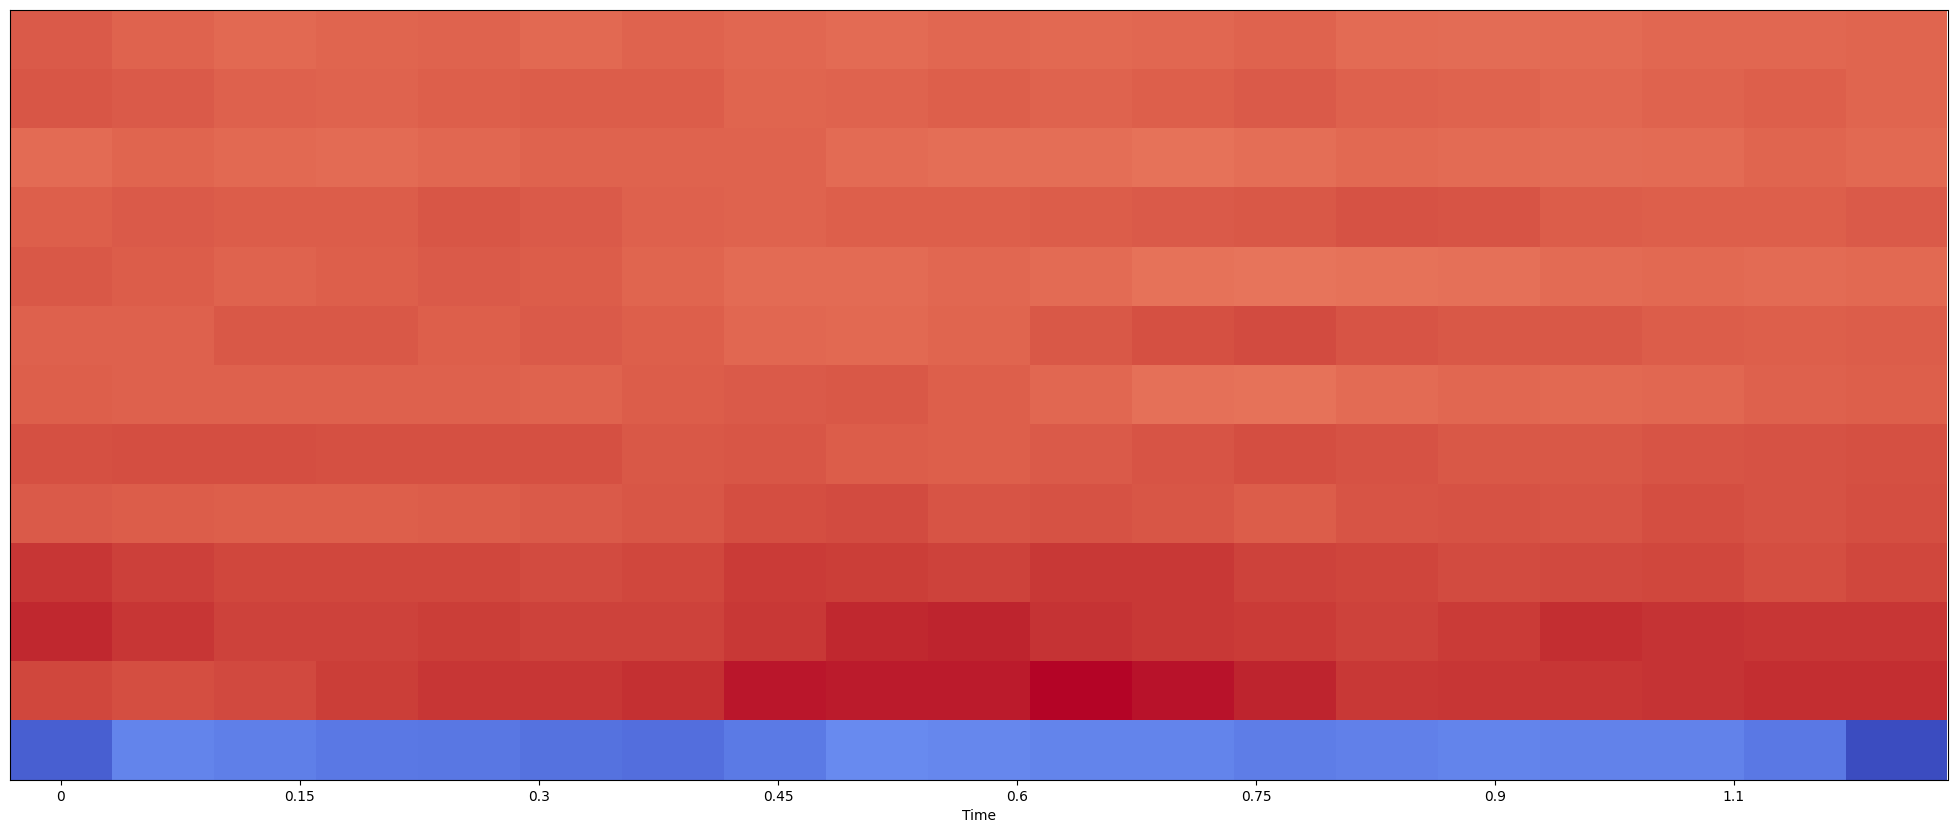

In [148]:
plt.figure(figsize=(25,10))
librosa.display.specshow(mfccs, x_axis = 'time', sr = sr)